# Projet DATA732
## Text Clustering by k-means with TfidfVectorizer
Clusters of the articles by the content after a preprocess applied to the content.    
Methode used: MiniBatchKMeans    
I will use MiniBatchKMeans because the reasult is similar to K-means and its faster to process.

## 0) Pre config

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import string 

from sklearn.manifold import TSNE
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer


## 1) Data

### 1.1) Input

In [2]:
df = pd.read_json('./new_df/df_multiple_articles.json', orient='records')
print(df.shape)
df.head(3)

(36600, 14)


,year,month,day,url,title,description,content,lang,kws,locations,miscellaneus,organizations,persons,domain
0,2019,1,1,https://fr.sputniknews.africa/20190102/macron-...,Macron reconnaît avoir répondu aux messages de...,L'Élysée a confirmé ce mercredi que le Préside...,"Lundi, quelques heures après qu'Alexandre Bena...",fr,"{'benalla': 12, 'macron': 11, 'message': 7, 'я...","{'État': 2, 'France': 3}",{},"{'Mediapart': 2, 'Canard': 2}","{'Alexandre Benalla': 3, 'Emmanuel Macron': 5,...",fr.sputniknews.africa
1,2019,1,1,https://fr.sputniknews.africa/20190102/saint-s...,Ce que l’on sait des attaques contre des passa...,Un homme a foncé avec sa voiture dans la nuit ...,Un conducteur qui aurait été motivé par des se...,fr,"{'police': 5, 'attaque': 5, 'étranger': 4, 'co...","{'Syrie': 2, 'Afghanistan': 2, 'Bottrop': 2, '...",{},{'ministre de l'Intérieur': 2},{},fr.sputniknews.africa
2,2019,1,1,https://fr.sputniknews.africa/20190102/tags-ra...,Des tags racistes appelant à «tuer les arabes»...,Dans un paisible village français de 4.200 âme...,"Comme l’écrit Nice Matin, Kill arabs sur un mu...",fr,"{'mur': 3, 'nuit': 2, 'véhicule': 2, 'village'...",{'Saint-Jeannet': 2},{},{},{},fr.sputniknews.africa


### 1.2) Text Processing

#### 1.2.1) Text with only keywords
(Not used)

In [3]:
combined_texts = []

for index, row in df.iterrows():
    all_words = {}
    for col in ['kws', 'miscellaneus', 'locations', 'organizations', 'persons']:
        for word, count in row[col].items():
            if word in all_words:
                all_words[word] += count
            else:
                all_words[word] = count
    
    combined_text = ' '.join([f'{word} ' * count for word, count in all_words.items()])
    
    # Append the combined text to the list
    combined_texts.append(combined_text)

df['combined_text_kws'] = combined_texts

#### 1.2.2) Content cleaning / Normalisation

In [4]:
list_suplementaire_stopwords = [
    'a', 'à', 'â', 'abord', 'afin', 'ah', 'ai', 'aie', 'ainsi', 'allaient',
    'allo', 'allô', 'allons', 'après', 'assez', 'attendu', 'au', 'aucun',
    'aucune', 'aujourd', "aujourd'hui", 'auquel', 'aura', 'auront', 'aussi',
    'autre', 'autres', 'aux', 'auxquelles', 'auxquels', 'avaient', 'avais',
    'avait', 'avant', 'avec', 'avoir', 'ayant', 'b', 'bah', 'beaucoup', 'bien',
    'bigre', 'boum', 'bravo', 'brrr', 'c', 'ça', 'car', 'ce', 'ceci', 'cela',
    'celle', 'celle-ci', 'celle-là', 'celles', 'celles-ci', 'celles-là',
    'celui', 'celui-ci', 'celui-là', 'cent', 'cependant', 'certain',
    'certaine', 'certaines', 'certains', 'certes', 'ces', 'cet', 'cette',
    'ceux', 'ceux-ci', 'ceux-là', 'chacun', 'chaque', 'cher', 'chère',
    'chères', 'chers', 'chez', 'chiche', 'chut', 'ci', 'cinq', 'cinquantaine',
    'cinquante', 'cinquantième', 'cinquième', 'clac', 'clic', 'combien',
    'comme', 'comment', 'compris', 'concernant', 'contre', 'couic', 'crac',
    'd', 'da', 'dans', 'de', 'debout', 'dedans', 'dehors', 'delà', 'depuis',
    'derrière', 'des', 'dès', 'désormais', 'desquelles', 'desquels', 'dessous',
    'dessus', 'deux', 'deuxième', 'deuxièmement', 'devant', 'devers', 'devra',
    'différent', 'différente', 'différentes', 'différents', 'dire', 'divers',
    'diverse', 'diverses', 'dix', 'dix-huit', 'dixième', 'dix-neuf', 'dix-sept',
    'doit', 'doivent', 'donc', 'dont', 'douze', 'douzième', 'dring', 'du',
    'duquel', 'durant', 'e', 'effet', 'eh', 'elle', 'elle-même', 'elles',
    'elles-mêmes', 'en', 'encore', 'entre', 'envers', 'environ', 'es', 'ès',
    'est', 'et', 'etant', 'étaient', 'étais', 'était', 'étant', 'etc', 'été',
    'etre', 'être', 'eu', 'euh', 'eux', 'eux-mêmes', 'excepté', 'f', 'façon',
    'fais', 'faisaient', 'faisant', 'fait', 'feront', 'fi', 'flac', 'floc',
    'font', 'g', 'gens', 'h', 'ha', 'hé', 'hein', 'hélas', 'hem', 'hep', 'hi',
    'ho', 'holà', 'hop', 'hormis', 'hors', 'hou', 'houp', 'hue', 'hui', 'huit',
    'huitième', 'hum', 'hurrah', 'i', 'il', 'ils', 'importe', 'j', 'je',
    'jusqu', 'jusque', 'k', 'l', 'la', 'là', 'laquelle', 'las', 'le', 'lequel',
    'les', 'lès', 'lesquelles', 'lesquels', 'leur', 'leurs', 'longtemps',
    'lorsque', 'lui', 'lui-même', 'm', 'ma', 'maint', 'mais', 'malgré', 'me',
    'même', 'mêmes', 'merci', 'mes', 'mien', 'mienne', 'miennes', 'miens',
    'mille', 'mince', 'moi', 'moi-même', 'moins', 'mon', 'moyennant', 'n', 'na',
    'ne', 'néanmoins', 'neuf', 'neuvième', 'ni', 'nombreuses', 'nombreux',
    'non', 'nos', 'notre', 'nôtre', 'nôtres', 'nous', 'nous-mêmes', 'nul', 'o',
    'o|', 'ô', 'oh', 'ohé', 'olé', 'ollé', 'on', 'ont', 'onze', 'onzième', 'ore',
    'ou', 'où', 'ouf', 'ouias', 'oust', 'ouste', 'outre', 'p', 'paf', 'pan',
    'par', 'parmi', 'partant', 'particulier', 'particulière',
    'particulièrement', 'pas', 'passé', 'pendant', 'personne', 'peu', 'peut',
    'peuvent', 'peux', 'pff', 'pfft', 'pfut', 'pif', 'plein', 'plouf', 'plus',
    'plusieurs', 'plutôt', 'pouah', 'pour', 'pourquoi', 'premier', 'première',
    'premièrement', 'près', 'proche', 'psitt', 'puisque', 'q', 'qu', 'quand',
    'quant', 'quanta', 'quant-à-soi', 'quarante', 'quatorze', 'quatre',
    'quatre-vingt', 'quatrième', 'quatrièmement', 'que', 'quel', 'quelconque',
    'quelle', 'quelles', 'quelque', 'quelques', 'quelquun', 'quels', 'qui',
    'quiconque', 'quinze', 'quoi', 'quoique', 'r', 'revoici', 'revoilà', 'rien',
    's', 'sa', 'sacrebleu', 'sans', 'sapristi', 'sauf', 'se', 'seize', 'selon',
    'sept', 'septième', 'sera', 'seront', 'ses', 'si', 'sien', 'sienne',
    'siennes', 'siens', 'sinon', 'six', 'sixième', 'soi', 'soi-même', 'soit',
    'soixante', 'son', 'sont', 'sous', 'stop', 'suis', 'suivant', 'sur',
    'surtout', 't', 'ta', 'tac', 'tant', 'te', 'té', 'tel', 'telle', 'tellement',
    'telles', 'tels', 'tenant', 'tes', 'tic', 'tien', 'tienne', 'tiennes',
    'tiens', 'toc', 'toi', 'toi-même', 'ton', 'touchant', 'toujours', 'tous',
    'tout', 'toute', 'toutes', 'treize', 'trente', 'très', 'trois',
    'troisième', 'troisièmement', 'trop', 'tsoin', 'tsouin', 'tu', 'u', 'un',
    'une', 'unes', 'uns', 'v', 'va', 'vais', 'vas', 'vé', 'vers', 'via', 'vif',
    'vifs', 'vingt', 'vivat', 'vive', 'vives', 'vlan', 'voici', 'voilà', 'vont',
    'vos', 'votre', 'vôtre', 'vôtres', 'vous', 'vous-mêmes', 'vu', 'w', 'x', 'y',
    'z', 'zut', 'alors', 'aucuns', 'bon', 'devrait', 'dos', 'droite', 'début',
    'essai', 'faites', 'fois', 'force', 'haut', 'ici', 'juste', 'maintenant',
    'mine', 'mot', 'nommés', 'nouveaux', 'parce', 'parole', 'personnes',
    'pièce', 'plupart', 'seulement', 'soyez', 'sujet', 'tandis', 'valeur',
    'voie', 'voient', 'état', 'étions'
]

listStopWords = stopwords.words('french') + stopwords.words('english') + list_suplementaire_stopwords + ['france', '2019', '2020', '2021']

In [5]:
sno = SnowballStemmer('french')

def cleanhtml(sentence):
    return BeautifulSoup(sentence, 'html.parser').get_text()

def cleanpunc(sentence):
    cleaned = "".join([char for char in sentence if char not in string.punctuation])
    return cleaned


In [6]:

final_string = []

for sent in df['content'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if cleaned_words.isalpha() and len(cleaned_words) > 2:
                if cleaned_words.lower() not in listStopWords:
                    s = sno.stem(cleaned_words.lower()).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence) 
    final_string.append(str1)

df['CleanedText'] = final_string
df['CleanedText'] = df['CleanedText'].str.decode("utf-8")

C:\Users\Carlos Andres Cortes\AppData\Local\Temp\ipykernel_20136\2599022119.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(sentence, 'html.parser').get_text()


## 2) Vectorization 

In [7]:
#Column name that will be used to apply the methode and number of clusters to search for.
id_column = 'CleanedText'
n_clusters = 7

### 2.1) K means using TF-IDF.

In [8]:
tfidf_vect = TfidfVectorizer(
    min_df =0.1
)
tfidf = tfidf_vect.fit_transform(df[id_column].values)
tfidf.shape

(36600, 289)

## 3) Clustering 

In [9]:
model_tf = MiniBatchKMeans(n_clusters=n_clusters, random_state=99)
model_tf.fit(tfidf)

c:\Users\Carlos Andres Cortes\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans(n_clusters=7, random_state=99)

In [10]:
labels_tf = model_tf.labels_
cluster_center_tf=model_tf.cluster_centers_

In [11]:
df1 = df
df1['Tfidf Clus Label'] = model_tf.labels_
df1.head(5)

,year,month,day,url,title,description,content,lang,kws,locations,miscellaneus,organizations,persons,domain,combined_text_kws,CleanedText,Tfidf Clus Label
0,2019,1,1,https://fr.sputniknews.africa/20190102/macron-...,Macron reconnaît avoir répondu aux messages de...,L'Élysée a confirmé ce mercredi que le Préside...,"Lundi, quelques heures après qu'Alexandre Bena...",fr,"{'benalla': 12, 'macron': 11, 'message': 7, 'я...","{'État': 2, 'France': 3}",{},"{'Mediapart': 2, 'Canard': 2}","{'Alexandre Benalla': 3, 'Emmanuel Macron': 5,...",fr.sputniknews.africa,benalla benalla benalla benalla benalla benall...,lund heur qualexandr benall affirm mediapart c...,2
1,2019,1,1,https://fr.sputniknews.africa/20190102/saint-s...,Ce que l’on sait des attaques contre des passa...,Un homme a foncé avec sa voiture dans la nuit ...,Un conducteur qui aurait été motivé par des se...,fr,"{'police': 5, 'attaque': 5, 'étranger': 4, 'co...","{'Syrie': 2, 'Afghanistan': 2, 'Bottrop': 2, '...",{},{'ministre de l'Intérieur': 2},{},fr.sputniknews.africa,police police police police police attaque at...,conducteur motiv sent xénophob fonc vol voitur...,5
2,2019,1,1,https://fr.sputniknews.africa/20190102/tags-ra...,Des tags racistes appelant à «tuer les arabes»...,Dans un paisible village français de 4.200 âme...,"Comme l’écrit Nice Matin, Kill arabs sur un mu...",fr,"{'mur': 3, 'nuit': 2, 'véhicule': 2, 'village'...",{'Saint-Jeannet': 2},{},{},{},fr.sputniknews.africa,mur mur mur nuit nuit véhicule véhicule vil...,nic matin kill arab mur signatur énigmat voitu...,4
3,2019,1,1,https://fr.sputniknews.africa/20190102/union-e...,Et le pays européen où l’on dépense le plus d’...,"Parmi tous les pays de l’Union européenne, l’E...",L'Office européen des statistiques Eurostat a ...,fr,"{'pays': 5, 'européen': 4, 'alcool': 4, 'boiss...","{'Lettonie': 2, 'Lituanie': 2}",{},{'Eurostat': 2},{},fr.sputniknews.africa,pays pays pays pays pays européen européen eu...,loffic européen statist eurostat calcul dépens...,4
4,2019,1,1,https://fr.sputniknews.africa/20190102/depot-p...,Le dépôt pétrolier près de Rouen bloqué par le...,Des dizaines de Gilets jaunes ont bloqué le 2 ...,"Le dépôt pétrolier de Rubis de Grand-Quevilly,...",fr,"{'dépôt': 7, 'gilet': 6, 'jaune': 6, 'pétrolie...",{'Rouen': 2},{'Gilets jaunes': 4},{},{},fr.sputniknews.africa,dépôt dépôt dépôt dépôt dépôt dépôt dépôt gil...,dépôt pétroli rub grandquevilly rouen seinemar...,5


In [12]:
# Number of articles in each cluster
df1.groupby(['Tfidf Clus Label'])['CleanedText'].count()

Tfidf Clus Label
0     1067
1     5103
2     4403
3     7019
4    12316
5     2949
6     3743
Name: CleanedText, dtype: int64

## 4) EDA

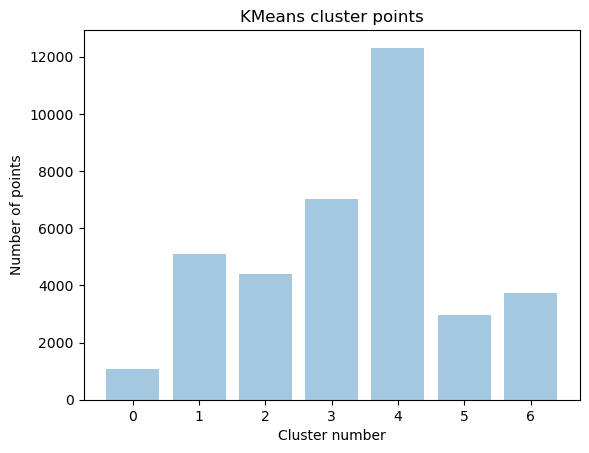

In [13]:
plt.bar([x for x in range(7)], df1.groupby(['Tfidf Clus Label'])[id_column].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [14]:
for i in range(7):
    print("4 review of assigned to cluster ", i)
    print("-" * 70)
    print(df1.iloc[df1.groupby(['Tfidf Clus Label']).groups[i][0]][id_column])
    print('\n')
    print(df1.iloc[df1.groupby(['Tfidf Clus Label']).groups[i][3]][id_column])
    print('\n')
    print(df1.iloc[df1.groupby(['Tfidf Clus Label']).groups[i][5]][id_column])
    print('\n')
    print("_" * 70)

4 review of assigned to cluster  0
----------------------------------------------------------------------
passag loccas fair bilan lann écoul lexercic doubl pertinent cors coalit national remport élect territorial décembr dexercic pouvoir régional estce résultat élus part polit autonom femu corsic franc faison cors mouv national corsic lib cré coalit corsic enfin rafl major sieg sein lassembl corseun nest peutêtr tir conclus déjà décompt nest valer bozz têt fil lopposit républicain national mimandat quil faut compt part déclar sputnik valer bozz aujourdhui bilan mimandat nest sputnik oxan bobrovitchvaler bozz républicain élu lassembl corsevaler bozz républicain élu lassembl sputnik oxan bobrovitch sûr labsenc réussit visibl lélu compt laiss termin mandat madam mair parl nom sent général popul lon ressent quil espoir mis collect uniqu mal constitu précipit niveau lorganigramm servic fonction cest labsenc projet linquiètent anné blanch invest collect commun représent manqu économ import 

In [15]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate='auto',
                      n_iter=2000, verbose=1, random_state=0, angle=0.75, init="random")

tsne_lda_vectors = tsne_lda_model.fit_transform(tfidf)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 36600 samples in 0.010s...
[t-SNE] Computed neighbors for 36600 samples in 913.857s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36600
[t-SNE] Computed conditional probabilities for sample 2000 / 36600
[t-SNE] Computed conditional probabilities for sample 3000 / 36600
[t-SNE] Computed conditional probabilities for sample 4000 / 36600
[t-SNE] Computed conditional probabilities for sample 5000 / 36600
[t-SNE] Computed conditional probabilities for sample 6000 / 36600
[t-SNE] Computed conditional probabilities for sample 7000 / 36600
[t-SNE] Computed conditional probabilities for sample 8000 / 36600
[t-SNE] Computed conditional probabilities for sample 9000 / 36600
[t-SNE] Computed conditional probabilities for sample 10000 / 36600
[t-SNE] Computed conditional probabilities for sample 11000 / 36600
[t-SNE] Computed conditional probabilities for sample 12000 / 36600
[t-SNE] Computed conditional probabilities for 

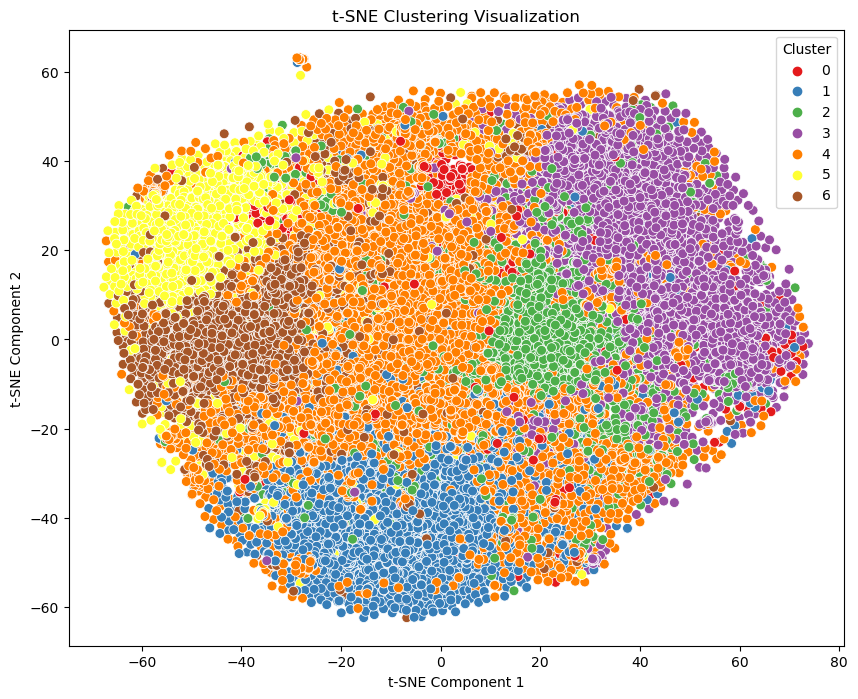

In [16]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_lda_vectors[:, 0], y=tsne_lda_vectors[:, 1], hue=df['Tfidf Clus Label'], palette='Set1', s=50)
plt.title('t-SNE Clustering Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

## 5) EDA

In [17]:
df['cluster'] = model_tf.labels_
df['vector1'] = tsne_lda_vectors[:, 0]
df['vector2'] = tsne_lda_vectors[:, 1]

In [18]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [19]:
df_final_draft = df[['date', 'url', 'domain', 'title', 'cluster', 'vector1', 'vector2']]
df_final_draft.head(5)

,date,url,domain,title,cluster,vector1,vector2
0,2019-01-01,https://fr.sputniknews.africa/20190102/macron-...,fr.sputniknews.africa,Macron reconnaît avoir répondu aux messages de...,2,19.860266,-1.958266
1,2019-01-01,https://fr.sputniknews.africa/20190102/saint-s...,fr.sputniknews.africa,Ce que l’on sait des attaques contre des passa...,5,-47.897854,14.720615
2,2019-01-01,https://fr.sputniknews.africa/20190102/tags-ra...,fr.sputniknews.africa,Des tags racistes appelant à «tuer les arabes»...,4,-55.927155,-10.909039
3,2019-01-01,https://fr.sputniknews.africa/20190102/union-e...,fr.sputniknews.africa,Et le pays européen où l’on dépense le plus d’...,4,36.497360,-25.957102
4,2019-01-01,https://fr.sputniknews.africa/20190102/depot-p...,fr.sputniknews.africa,Le dépôt pétrolier près de Rouen bloqué par le...,5,-47.172798,15.631112


In [20]:
df_final_draft['domain'].unique()

array(['fr.sputniknews.africa', 'www.egaliteetreconciliation.fr',
       'french.presstv.ir', 'www.fdesouche.com'], dtype=object)

In [21]:
# Save the DataFrame to a JSON file

# df_final_draft.to_json('./results/df_final_kmean.txt')

In [22]:
# Save the DataFrame to a CSV file

# df_final_draft.to_csv('./results/df_final_kmean-tfidf.csv', index=False)